In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import re
import nltk
import spacy
nlp = spacy.load('en_core_web_sm')
from collections import Counter
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/gloveicg/Glove/glove.6B.50d.txt
/kaggle/input/gloveicg/Glove/glove.6B.200d.txt
/kaggle/input/gloveicg/Glove/glove.6B.100d.txt
/kaggle/input/gloveicg/Glove/glove.6B.300d.txt
/kaggle/input/gloveicg/glove/Glove/glove.6B.50d.txt
/kaggle/input/gloveicg/glove/Glove/glove.6B.200d.txt
/kaggle/input/gloveicg/glove/Glove/glove.6B.100d.txt
/kaggle/input/gloveicg/glove/Glove/glove.6B.300d.txt
/kaggle/input/nlp-getting-started/train.csv
/kaggle/input/nlp-getting-started/test.csv
/kaggle/input/nlp-getting-started/sample_submission.csv


# 1. Importing and Cleaning Data

In [2]:
train = pd.read_csv("/kaggle/input/nlp-getting-started/train.csv")
test = pd.read_csv("/kaggle/input/nlp-getting-started/test.csv")
sample_submission = pd.read_csv("/kaggle/input/nlp-getting-started/sample_submission.csv")

In [3]:
train.head(2)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1


### Expand contractions, e.g. hasn't -> has not

In [4]:
def decontracted(phrase):
    # specific
    phrase = re.sub(r"won\'t", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase) #This confuses contraction with possession
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [5]:
train['cleanedText'] = train.text.map(lambda x: decontracted(x))
test['cleanedText'] = test.text.map(lambda x: decontracted(x))

### Remove URLs from tweets, save into new column cleanedText 

In [6]:
def removeURL(text):
    for eachToken in nlp(text):
        match = re.search("((http|https)\:\/\/)?[a-zA-Z0-9\.\/\?\:@\-_=#]+\.([a-zA-Z]){2,6}([a-zA-Z0-9\.\&\/\?\:@\-_=#])*", eachToken.text)
        if match:
            text = text.replace(eachToken.text, "")
    return text
train['cleanedText'] = train.cleanedText.apply(removeURL)
test['cleanedText'] = test.cleanedText.apply(removeURL)

### (1) Tokenize tweets; (2) Removing stopwords (including symbols); (3) Lemmatize and lowercase the remaining tokens for both train and test set and (4) save in column cleanedText

In [7]:
from nltk.corpus import stopwords
stopWords = set(stopwords.words('english'))
# for each in "~`!@#$%^&?*()_+?|/<>.,[]-:;'":
#     stopWords.add(each)
stopWords.remove('no')
stopWords.remove('not')
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
from nltk.tokenize import word_tokenize
train['cleanedText'] = train.cleanedText.map(lambda x: ' '.join([lemmatizer.lemmatize(each.text.lower()) for each in nlp(x) if each.text.lower() not in stopWords]))
test['cleanedText'] = test.cleanedText.map(lambda x: ' '.join([lemmatizer.lemmatize(each.text.lower()) for each in nlp(x) if each.text.lower() not in stopWords]))
train[['text','cleanedText']].head()

,text,cleanedText
0,Our Deeds are the Reason of this #earthquake M...,deed reason # earthquake may allah forgive u
1,Forest fire near La Ronge Sask. Canada,forest fire near la ronge sask . canada
2,All residents asked to 'shelter in place' are ...,resident asked ishelter place ' notified off...
3,"13,000 people receive #wildfires evacuation or...","13,000 people receive # wildfire evacuation or..."
4,Just got sent this photo from Ruby #Alaska as ...,got sent photo ruby # alaska smoke # wildfire ...


### Concatenate location and keyword into the beginning of the tweets

In [8]:
# Concatenate keyword
train['keyword'] = train.keyword.astype(str)
test['keyword'] = test.keyword.astype(str)
train['cleanedText'] = train.apply(lambda x: x.cleanedText if x.keyword == 'nan' else x.keyword.lower() + ' ' + x.cleanedText, axis = 1)
test['cleanedText'] = test.apply(lambda x: x.cleanedText if x.keyword == 'nan' else x.keyword.lower() + ' ' + x.cleanedText, axis = 1)

# Concatenate location
train['location'] = train.location.astype(str)
test['location'] = train.location.astype(str)
train['cleanedText'] = train.apply(lambda x: x.cleanedText if x.location == 'nan' else x.location.lower() + ' ' + x.cleanedText, axis = 1)
test['cleanedText'] = test.apply(lambda x: x.cleanedText if x.location == 'nan' else x.location.lower() + ' ' + x.cleanedText, axis = 1)

# 2. Descriptive Analysis

In [9]:
# Build a manual counter
counter = Counter()
for eachWord in word_tokenize(' '.join(train.cleanedText.tolist())):
    if (eachWord.lower() not in stopWords)&(eachWord.lower()!=''):
        counter[eachWord.lower()] += 1

In [10]:
print("Columns in train: {}".format(', '.join(train.columns.values)))
print(f"Count of tweets in train: {train.shape[0]}")
print('Count of true tweets: {}'.format(train.target.value_counts()[1]))
print('Count of fake tweets: {}'.format(train.target.value_counts()[0]))
print("Top 10 keywords: {}".format(', '.join(train.keyword.value_counts()[:10].index.values)))
print('Top 10 locations: {}'.format(', '.join(train.location.value_counts()[:10].index.values)))
print("Total number of words in all tweets: {}".format(len(counter)))
print("Most common words or symbols used in tweets: {}".format(', '.join([each[0] for each in counter.most_common()[:20]])))

Columns in train: id, keyword, location, text, target, cleanedText
Count of tweets in train: 7613
Count of true tweets: 3271
Count of fake tweets: 4342
Top 10 keywords: nan, fatalities, deluge, armageddon, damage, harm, sinking, body%20bags, siren, evacuate
Top 10 locations: nan, USA, New York, United States, London, Canada, Nigeria, UK, Los Angeles, CA, India
Total number of words in all tweets: 18513
Most common words or symbols used in tweets: ?, #, ., @, :, ,, -, ', %, !, ..., not, ;, &, new, _, fire, ), (, like


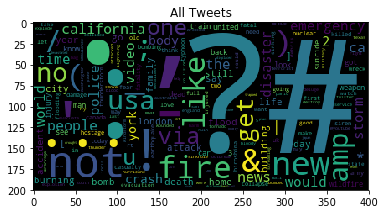

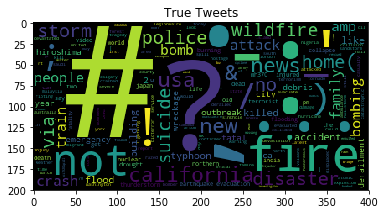

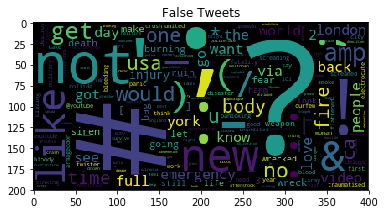

In [11]:
from wordcloud import WordCloud
allTokens = [each.text for each in nlp(' '.join(train.cleanedText.tolist()))]
allTokensTrueTweets = [each.text for each in nlp(' '.join(train[train.target == 1].cleanedText.tolist()))]
allTokensFalseTweets = [each.text for each in nlp(' '.join(train[train.target == 0].cleanedText.tolist()))]
frequency_dist = nltk.FreqDist(allTokens)
frequency_dist_trueTweets = nltk.FreqDist(allTokensTrueTweets)
frequency_dist_falseTweets = nltk.FreqDist(allTokensFalseTweets)
wordcloud = WordCloud().generate_from_frequencies(frequency_dist)
wordcloud_trueTweets = WordCloud().generate_from_frequencies(frequency_dist_trueTweets)
wordcloud_falseTweets = WordCloud().generate_from_frequencies(frequency_dist_falseTweets)

plt.imshow(wordcloud)
plt.title("All Tweets")
plt.show()
plt.imshow(wordcloud_trueTweets)
plt.title("True Tweets")
plt.show()
plt.imshow(wordcloud_falseTweets)
plt.title("False Tweets")
plt.show()

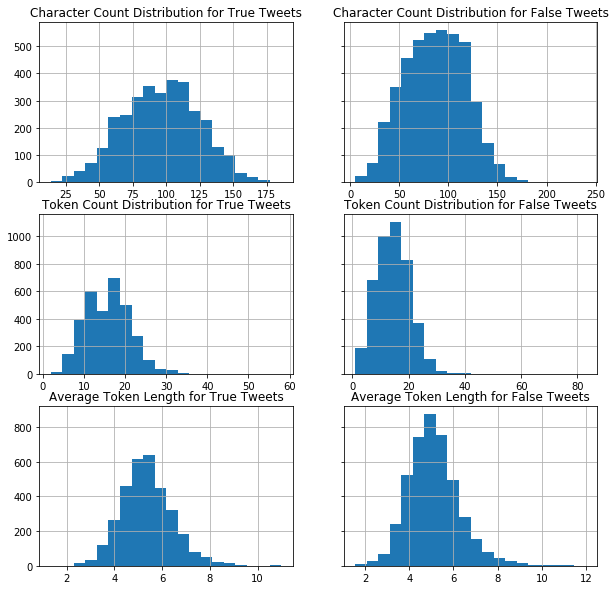

In [12]:
fig, axs = plt.subplots(3,2, sharey = 'row', figsize = (10,10))
train.apply(lambda x: len(x.cleanedText) if x.target == 1 else None, axis = 1).hist(bins = 20, ax = axs[0,0])
axs[0,0].set_title("Character Count Distribution for True Tweets")
train.apply(lambda x: len(x.cleanedText) if x.target == 0 else None, axis = 1).hist(bins = 20, ax = axs[0,1])
axs[0,1].set_title("Character Count Distribution for False Tweets")
train.apply(lambda x: len(x.cleanedText.split(' ')) if x.target == 1 else None, axis = 1).hist(bins = 20, ax = axs[1,0])
axs[1,0].set_title("Token Count Distribution for True Tweets")
train.apply(lambda x: len(x.cleanedText.split(' ')) if x.target == 0 else None, axis = 1).hist(bins = 20, ax = axs[1,1])
axs[1,1].set_title("Token Count Distribution for False Tweets")
train.apply(lambda x: np.mean(list(map(len, x.cleanedText.split(' ')))) if x.target == 1 else None, axis = 1).hist(bins = 20, ax = axs[2,0])
axs[2,0].set_title("Average Token Length for True Tweets")
train.apply(lambda x: np.mean(list(map(len, x.cleanedText.split(' ')))) if x.target == 0 else None, axis = 1).hist(bins = 20, ax = axs[2,1])
axs[2,1].set_title("Average Token Length for False Tweets")
plt.show()

# 3. Vectorize tweets with TF-IDF and Make predictions with Naive Bayes

#### Vectorize tweets with TFIDF and Store the Document Term Matrix in tfidf_dtm

In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer
vect = TfidfVectorizer()
vect.fit(train.cleanedText)
tfidf_dtm = pd.DataFrame(vect.transform(train.cleanedText.tolist()).toarray(), index = train.id, columns = vect.get_feature_names())
print("Vocabulary size from all the tweets: {}".format(len(vect.vocabulary_)))

Vocabulary size from all the tweets: 17710


#### Split tfidf_dtm into model-ready variables

In [14]:
import random
train_index = random.sample(list(np.arange(0, tfidf_dtm.shape[0])), int(tfidf_dtm.shape[0]/2))
train_index.sort()
train_features = tfidf_dtm.iloc[train_index]
test_features = tfidf_dtm.iloc[[index for index in np.arange(0, tfidf_dtm.shape[0]) if index not in train_index]]
train_target = train.iloc[train_index].target
test_target = train.iloc[[index for index in np.arange(0, train.shape[0]) if index not in train_index]].target
print("Train set has {} true tweets and {} false tweets.".format(train_target.value_counts().loc[1], train_target.value_counts().loc[0]))
print("Test set has {} true tweets and {} false tweets.".format(test_target.value_counts().loc[1], test_target.value_counts().loc[0]))

Train set has 1599 true tweets and 2207 false tweets.
Test set has 1672 true tweets and 2135 false tweets.


#### (1) Train Model, (2) Make Predictions, and (3) Analyze Classification Performance

In [15]:
from sklearn.naive_bayes import MultinomialNB
classifier = MultinomialNB().fit(train_features, train_target)
test_predictions = classifier.predict(test_features)
from sklearn.metrics import classification_report
print(classification_report(test_target, test_predictions))

              precision    recall  f1-score   support

           0       0.75      0.91      0.82      2135
           1       0.84      0.61      0.71      1672

    accuracy                           0.78      3807
   macro avg       0.80      0.76      0.77      3807
weighted avg       0.79      0.78      0.77      3807



#### Comment: Since the task is to identify true disaster tweets, the metric that we should focus here is recall for true tweets, i.e. the ratio of correctly predicted true tweets to all true tweets. We want to maximize recall, even at the expense of precision (i.e. the ratio of correctedly predicted true tweets to all the predicted true tweets). The reason is we want to be able to identify all true disaster tweets so emergency can be deployed in a timely manner; even if we mistakenly identify some false tweets as true disasters and the emergency service receives some false alarms. However, since we don't have a severe case of class imbalance, we also care about general accuracy. The accuracy here is a fine starting benchmark.

#### Here, the recall for true tweets is low. Next up I'll try using pretrained word embeddings GloVe with RNN.

# 3'.Run prediction on submission test set

In [16]:
test_dtm = pd.DataFrame(vect.transform(test.text).toarray(), index = test.id, columns = vect.get_feature_names())
classifier.predict(test_dtm)
submission_prediction = pd.DataFrame(classifier.predict(test_dtm), columns = ['target'])
submission_prediction['id'] = test.id
submission_prediction = submission_prediction[['id', 'target']]
os.chdir("/kaggle/working/")
submission_prediction.to_csv('submission.csv', index = False)

# 4. Import Pretrained Word Embedding Model GloVe

#### Import the GloVe model from .txt file

In [17]:
os.chdir("/kaggle/input/gloveicg")
gloveFile = open("/kaggle/input/gloveicg/Glove/glove.6B.300d.txt")
print("First line in gloveFile: {}".format(gloveFile.readline()))

First line in gloveFile: the 0.04656 0.21318 -0.0074364 -0.45854 -0.035639 0.23643 -0.28836 0.21521 -0.13486 -1.6413 -0.26091 0.032434 0.056621 -0.043296 -0.021672 0.22476 -0.075129 -0.067018 -0.14247 0.038825 -0.18951 0.29977 0.39305 0.17887 -0.17343 -0.21178 0.23617 -0.063681 -0.42318 -0.11661 0.093754 0.17296 -0.33073 0.49112 -0.68995 -0.092462 0.24742 -0.17991 0.097908 0.083118 0.15299 -0.27276 -0.038934 0.54453 0.53737 0.29105 -0.0073514 0.04788 -0.4076 -0.026759 0.17919 0.010977 -0.10963 -0.26395 0.07399 0.26236 -0.1508 0.34623 0.25758 0.11971 -0.037135 -0.071593 0.43898 -0.040764 0.016425 -0.4464 0.17197 0.046246 0.058639 0.041499 0.53948 0.52495 0.11361 -0.048315 -0.36385 0.18704 0.092761 -0.11129 -0.42085 0.13992 -0.39338 -0.067945 0.12188 0.16707 0.075169 -0.015529 -0.19499 0.19638 0.053194 0.2517 -0.34845 -0.10638 -0.34692 -0.19024 -0.2004 0.12154 -0.29208 0.023353 -0.11618 -0.35768 0.062304 0.35884 0.02906 0.0073005 0.0049482 -0.15048 -0.12313 0.19337 0.12173 0.44503 0.2514

In [18]:
gloveModel = {}
gloveFile.seek(0) # Return the cursor back to the beginning of the file
for line in gloveFile.readlines():
    lineElements = line.split(" ")
    token = lineElements[0]
    tokenEmbedding = [float(each) for each in lineElements[1:]]
    gloveModel[token] = tokenEmbedding
gloveMatrix = pd.DataFrame(gloveModel).T
gloveMatrix.head()

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
the,0.046560,0.213180,-0.007436,-0.458540,-0.035639,0.236430,-0.288360,0.215210,-0.134860,-1.6413,...,-0.013064,-0.296860,-0.079913,0.195000,0.031549,0.285060,-0.087461,0.009061,-0.209890,0.053913
",",-0.255390,-0.257230,0.131690,-0.042688,0.218170,-0.022702,-0.178540,0.107560,0.058936,-1.3854,...,0.075968,-0.014359,-0.073794,0.221760,0.146520,0.566860,0.053307,-0.232900,-0.122260,0.354990
.,-0.125590,0.013630,0.103060,-0.101230,0.098128,0.136270,-0.107210,0.236970,0.328700,-1.6785,...,0.060148,-0.156190,-0.119490,0.234450,0.081367,0.246180,-0.152420,-0.342240,-0.022394,0.136840
of,-0.076947,-0.021211,0.212710,-0.722320,-0.139880,-0.122340,-0.175210,0.121370,-0.070866,-1.5721,...,-0.366730,-0.386030,0.302900,0.015747,0.340360,0.478410,0.068617,0.183510,-0.291830,-0.046533
to,-0.257560,-0.057132,-0.671900,-0.380820,-0.364210,-0.082155,-0.010955,-0.082047,0.460560,-1.8477,...,-0.012806,-0.597070,0.317340,-0.252670,0.543840,0.063007,-0.049795,-0.160430,0.046744,-0.070621


#### Exploring GloVe

In [19]:
def findClosestWordToWord(word):
    diffMatrix = gloveMatrix - gloveModel[word]
    diffMatrix = diffMatrix * diffMatrix
    diffMatrix.drop(word, axis = 0, inplace = True)
    return diffMatrix.sum(axis = 1).idxmin()
def findClosestWordToEmbedding(embedding, excludedWords):
    diffMatrix = gloveMatrix - embedding
    diffMatrix = diffMatrix * diffMatrix
    diffMatrix.drop(excludedWords, axis = 0, inplace = True)
    return diffMatrix.sum(axis = 1).idxmin()

In [20]:
temp = gloveMatrix.loc['father'] - gloveMatrix.loc['mother'] + gloveMatrix.loc['daughter']
print("Father to Mother is like {} to Daughter".format(findClosestWordToEmbedding(temp, ['father', 'mother', 'daughter']).title()))
print("The closest word to Data is {}".format(findClosestWordToWord('data').title()))

Father to Mother is like Son to Daughter
The closest word to Data is Information


# 5. Using GloVe

In [21]:
print("Size of vocabulary in GloVe: ",gloveMatrix.shape[0])
print("Size of vocabulary from all tweets: ",len(vect.get_feature_names()))
print("Size of overlapped vocabulary:" , len(set(gloveMatrix.index).intersection(set(vect.get_feature_names()))))

print("Since we want to use word embedding to train model, we need to remove tokens that do not appear in GloVe")
train['cleanedText2'] = train.cleanedText.map(lambda x: ' '.join([each for each in word_tokenize(x) if each in gloveModel.keys()]))
test['cleanedText2'] = test.cleanedText.map(lambda x: ' '.join([each for each in word_tokenize(x) if each in gloveModel.keys()]))

train.dropna(subset=['text', 'cleanedText', 'cleanedText2'], inplace = True)
# test.dropna(subset=['text', 'cleanedText', 'cleanedText2'], inplace = True)

# Drop tweets whose cleanedText2 is empty
temp = (train.cleanedText2.apply(len) == 0)
train.drop(temp[temp == True].index, axis = 0, inplace = True)
del temp

# temp = (test.cleanedText2.apply(len) == 0)
# test.drop(temp[temp == True].index, axis = 0, inplace = True)
# del temp

train[['text', 'cleanedText', 'cleanedText2']].head(2)

Size of vocabulary in GloVe:  400000
Size of vocabulary from all tweets:  17710
Size of overlapped vocabulary: 12628
Since we want to use word embedding to train model, we need to remove tokens that do not appear in GloVe


,text,cleanedText,cleanedText2
0,Our Deeds are the Reason of this #earthquake M...,deed reason # earthquake may allah forgive u,deed reason # earthquake may allah forgive u
1,Forest fire near La Ronge Sask. Canada,forest fire near la ronge sask . canada,forest fire near la ronge sask . canada


In [22]:
# Interestingly, i see '13,000' is reserved in cleanedText2 for a row
# Finding out whether 13,000 is in GloVe vocabulary
print("'13,000' is in GloVe vocabulary: {}".format('13,000' in gloveModel.keys()))
print("The word closest to '13,000' is '{}'".format(findClosestWordToWord('13,000')))

'13,000' is in GloVe vocabulary: True
The word closest to '13,000' is '12,000'


# 6. Keras RNN Model

#### Convert texts into sequences

In [23]:
# Create a GloVe dictionary where keys are tokens and values are respective numeric indices 
gloveDict = {}
for index, eachWord in enumerate(gloveMatrix.index):
    gloveDict[eachWord] = index
    
# Using GloVe dictionary, convert train.cleanedText2 to sequences of numeric indices of respective tokens
def texts_to_sequences(textSeries):
    return textSeries.map(lambda x: [gloveDict['.']] if len(x) == 0 else [gloveDict[each] for each in x.split(" ")])
    # if cleanedText2 is empty then fill the string with '.' (to meet submission criterion of full test set)
    
train['sequence'] = texts_to_sequences(train.cleanedText2)
test['sequence'] = texts_to_sequences(test.cleanedText2)  

# Padding these sequences with periods '.'. I use the length of the longest sequence in train as the max for both train and submission test sets 
maxlen = np.max(train.sequence.map(lambda x: len(x)))
train['padded_sequence'] = train.sequence.map(lambda x: x[:maxlen] if len(x) >= maxlen else x + [gloveDict['.']]*(maxlen-len(x)))
test['padded_sequence'] = test.sequence.map(lambda x: x[:maxlen] if len(x) >= maxlen else x + [gloveDict['.']]*(maxlen-len(x)))

#### Prepare model-ready variables

In [24]:
train_index = random.sample(list(np.arange(0, train.shape[0])), int(train.shape[0]/2))
train_index.sort()
train_features = train.iloc[train_index]['padded_sequence']
train_features = pd.DataFrame([each for each in train_features])
train_target = train.iloc[train_index]['target']
test_features = train.iloc[[i for i in np.arange(0, train.shape[0]) if i not in train_index]]['padded_sequence']
test_features = pd.DataFrame([each for each in test_features])
test_target = train.iloc[[i for i in np.arange(0, train.shape[0]) if i not in train_index]]['target']
print("Train set has {} true tweets and {} false tweets.".format(train_target.value_counts().loc[1], train_target.value_counts().loc[0]))
print("Test set has {} true tweets and {} false tweets.".format(test_target.value_counts().loc[1], test_target.value_counts().loc[0]))

Train set has 1648 true tweets and 2158 false tweets.
Test set has 1623 true tweets and 2183 false tweets.


#### Building the model

In [25]:
from tensorflow.keras import metrics
from tensorflow.keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
METRICS = [
    metrics.BinaryAccuracy(name = 'accuracy'),
    metrics.Precision(name = 'precision'),
    metrics.Recall(name = 'recall'),
    metrics.AUC(name = 'auc')
]
early_stopping = EarlyStopping(
    monitor = 'val_auc',
    verbose = 1,
    patience = 10,
    mode = 'max',
    restore_best_weights = True
)
checkpoint = ModelCheckpoint('model-{epoch}-{loss}-{val_loss}.h5', verbose = 1, \
                             monitor = 'val_loss', save_best_only = True, mode = 'auto')

Using TensorFlow backend.


In [26]:
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, GRU, Bidirectional, BatchNormalization, Dropout
from keras.initializers import Constant
from keras.optimizers import SGD, Adam, RMSprop
model = Sequential()
embedding_layer = Embedding(input_dim = gloveMatrix.shape[0], output_dim = gloveMatrix.shape[1],\
                            embeddings_initializer = Constant(gloveMatrix.to_numpy()),\
                           input_length = maxlen, trainable = False)
model.add(embedding_layer)
model.add(Bidirectional(LSTM(units=64, dropout = 0.5, recurrent_dropout = 0.5)))
model.add(Dense(32))
model.add(Dense(1, activation = 'sigmoid'))

model.compile(loss = 'binary_crossentropy', optimizer = RMSprop(lr = 0.0002), metrics = METRICS)
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 72, 300)           120000000 
_________________________________________________________________
bidirectional_1 (Bidirection (None, 128)               186880    
_________________________________________________________________
dense_1 (Dense)              (None, 32)                4128      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 120,191,041
Trainable params: 191,041
Non-trainable params: 120,000,000
_________________________________________________________________


#### Training the model

In [27]:
history = model.fit(train_features, train_target, epochs = 35, batch_size = 32, \
                    validation_data = (test_features, test_target))

Train on 3806 samples, validate on 3806 samples
Epoch 1/35
3806/3806 [==============================] - 22s 6ms/step - loss: 0.6667 - accuracy: 0.5441 - precision: 0.4575 - recall: 0.2680 - auc: 0.5537 - val_loss: 0.6169 - val_accuracy: 0.6251 - val_precision: 0.6132 - val_recall: 0.3115 - val_auc: 0.6558
Epoch 2/35
3806/3806 [==============================] - 20s 5ms/step - loss: 0.6000 - accuracy: 0.6489 - precision: 0.6735 - recall: 0.3546 - auc: 0.6952 - val_loss: 0.5489 - val_accuracy: 0.6707 - val_precision: 0.6860 - val_recall: 0.4219 - val_auc: 0.7196
Epoch 3/35
3806/3806 [==============================] - 19s 5ms/step - loss: 0.5645 - accuracy: 0.6837 - precision: 0.6989 - recall: 0.4660 - auc: 0.7346 - val_loss: 0.5279 - val_accuracy: 0.6957 - val_precision: 0.7082 - val_recall: 0.4918 - val_auc: 0.7462
Epoch 4/35
3806/3806 [==============================] - 20s 5ms/step - loss: 0.5485 - accuracy: 0.7014 - precision: 0.7150 - recall: 0.5089 - auc: 0.7531 - val_loss: 0.5177 - 

#### Visualizing the model loss

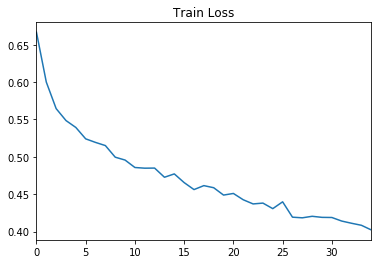

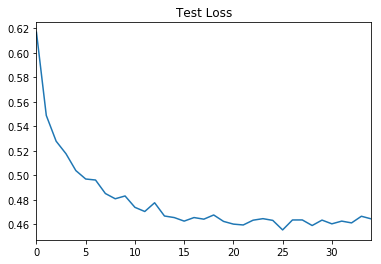

In [28]:
historyDF = pd.DataFrame(history.history)
historyDF.loss.plot()
plt.title("Train Loss")
plt.show()
historyDF.val_loss.plot()
plt.title("Test Loss")
plt.show()
# plt.title('Visualizing Loss')

#### Making Predictions and Creating Classification Report test set

In [29]:
test_predictions = pd.Series(model.predict(test_features).reshape(-1,),name = 'test_prediction')
threshold = 0.45
test_classPredictions = pd.Series(np.where(test_predictions > threshold, 1, 0), name = 'test_classPredictions')
print(classification_report(test_target, test_classPredictions))

              precision    recall  f1-score   support

           0       0.80      0.85      0.83      2183
           1       0.79      0.72      0.75      1623

    accuracy                           0.80      3806
   macro avg       0.80      0.79      0.79      3806
weighted avg       0.80      0.80      0.80      3806



#### Comment: Recall appears to increase for true tweets with low enough threshold, although the overall accuracy of the model is the same with Naive Bayes

# 7. Run prediction on submission test set

In [30]:
submissionTest_features = test['padded_sequence']
submissionTest_features = pd.DataFrame([each for each in submissionTest_features])

submissionTest_Predictions = model.predict(submissionTest_features).reshape(-1,)
submissionTest_classPredictions = pd.Series(np.where(submissionTest_Predictions > 0.35, 1, 0), name = 'target')

submission_prediction = pd.DataFrame({'id': test.id.values, 'target': submissionTest_classPredictions.values})

os.chdir("/kaggle/working")
submission_prediction = submission_prediction.to_csv("submission.csv", index = False)